<a href="https://colab.research.google.com/github/Irina-64/AI_University/blob/main/%D0%A0%D0%B0%D0%B7%D0%B1%D0%BE%D1%80_%D0%94%D0%97_4_Pro_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Dropout, Conv1D# Слои для сети
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

import pandas as pd
import numpy as np


In [ ]:
!rm -R /content/texts # Проверяем наличие папки texts. Если есть, удаляем ее

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Тексты писателей.zip' -d '/content/texts'

# Шаблон с ноута

In [ ]:
# Запускаем все необходимые функции

def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку
  
  return (xSamples, ySamples) # Функция возвращает выборку и соответствующие векторы классов

# Создаем функцию подготовки данных
def creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100):
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

    # Преобразовываем текст в последовательность индексов согласно частотному словарю
    trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
    testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

    #Формируем обучающую и тестовую выборку
    xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
    xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

    # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest

#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



# LIGHT

Вариант 1

Выполните задания, по каждому варианту напишите точность распознавания на проверочной выборке и сделайте выводы. (тексты писателей)
Запустите нейронку c bag of words (01) при разных maxWordsCount

* 100
* 1000
* 10000
* 50000

Запустите нейронку c bag of words (01) при maxWordsCount = 20000 и разных архитектурах

* Поменяйте количество нейронов в слоях
* Поменяйте количество слоев
* Поменяйте активационные функции слоев

Запустите нейронку c Embbedding при maxWordsCount = 50000, поменяйте размер Embedding пространства
* 10
* 50
* 200


In [ ]:
# Создаем функцию подготовки данных
def creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100):
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

    # Преобразовываем текст в последовательность индексов согласно частотному словарю
    trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
    testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

    #Формируем обучающую и тестовую выборку
    xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
    xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

    # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest

In [ ]:
_, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100)

Epoch 1/10
120/120 [==============================] - 1s 11ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.2659 - val_accuracy: 0.9371
Epoch 2/10
120/120 [==============================] - 1s 9ms/step - loss: 4.7789e-04 - accuracy: 1.0000 - val_loss: 0.2274 - val_accuracy: 0.9356
Epoch 3/10
120/120 [==============================] - 1s 9ms/step - loss: 2.3994e-04 - accuracy: 1.0000 - val_loss: 0.2213 - val_accuracy: 0.9347
Epoch 4/10
120/120 [==============================] - 1s 9ms/step - loss: 1.5261e-04 - accuracy: 1.0000 - val_loss: 0.2203 - val_accuracy: 0.9318
Epoch 5/10
120/120 [==============================] - 1s 9ms/step - loss: 1.1508e-04 - accuracy: 1.0000 - val_loss: 0.2186 - val_accuracy: 0.9309
Epoch 6/10
120/120 [==============================] - 1s 9ms/step - loss: 9.1850e-05 - accuracy: 1.0000 - val_loss: 0.2170 - val_accuracy: 0.9316
Epoch 7/10
120/120 [==============================] - 1s 9ms/step - loss: 7.4666e-05 - accuracy: 1.0000 - val_loss: 0.2152 - va

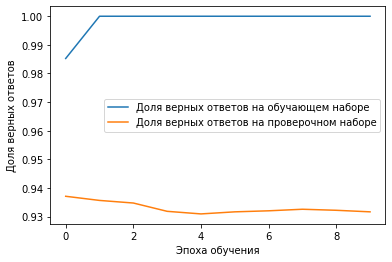

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=15000, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
data = [[1, 200, 'relu', 15000, None, round(history.history['val_accuracy'][-1], 3)]]
data

[[1, 200, 'relu', 15000, None, 0.932]]

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

4312

In [ ]:
# 1
maxWordsCountList = [10,1000,10000,25000]
for i in maxWordsCountList:
    # чистим оперативную память
    gc.collect()
    # Подготавливаем данные
    _, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = i, xLen = 1000, step = 100)
    # Создаем сеть
    model01 = Sequential()
    model01.add(Dense(200, input_dim=i, activation="relu")) # Указываем входной размер 
    model01.add(Dropout(0.25))
    model01.add(BatchNormalization())
    model01.add(Dense(6, activation='softmax'))

    model01.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    #Обучаем сеть на выборке, сформированной по bag of words - xTrain01
    history = model01.fit(xTrain01, 
                        yTrain, 
                        epochs=10,
                        batch_size=128,
                        validation_data=(xTest01, yTest))
    data = data + [[1, 200, 'relu', i, None, round(history.history['val_accuracy'][-1], 3)]]

# 2.1
# Подготавливаем данные
_, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = 20000, xLen = 1000, step = 100)

neurons_list = [10, 50, 100, 500, 1000, 2000]

for i in neurons_list:
    # чистим оперативную память
    gc.collect()
    # Создаем сеть
    model01 = Sequential()
    model01.add(Dense(i, input_dim=20000, activation="relu")) # Указываем кол-во нейронов
    model01.add(Dropout(0.25))
    model01.add(BatchNormalization())
    model01.add(Dense(6, activation='softmax'))

    model01.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    #Обучаем сеть на выборке, сформированной по bag of words - xTrain01
    history = model01.fit(xTrain01, 
                        yTrain, 
                        epochs=10,
                        batch_size=128,
                        validation_data=(xTest01, yTest))
    data = data + [[1, i, 'relu', 20000, None, round(history.history['val_accuracy'][-1], 3)]]

# 2.2
for i in neurons_list:
    # чистим оперативную память
    gc.collect()
    # Создаем сеть
    model01 = Sequential()
    model01.add(Dense(i, input_dim=20000, activation="relu")) # Указываем кол-во нейронов
    model01.add(Dense(i, activation="relu"))                  # Добавляем еще один слой
    model01.add(Dropout(0.25))
    model01.add(BatchNormalization())
    model01.add(Dense(6, activation='softmax'))

    model01.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    #Обучаем сеть на выборке, сформированной по bag of words - xTrain01
    history = model01.fit(xTrain01, 
                        yTrain, 
                        epochs=10,
                        batch_size=128,
                        validation_data=(xTest01, yTest))
    data = data + [[2, i, 'relu', 20000, None, round(history.history['val_accuracy'][-1], 3)]]

# 2.3
# чистим оперативную память
gc.collect()
# Создаем сеть
model01 = Sequential()
model01.add(Dense(200, input_dim=20000, activation="linear")) # Указываем активационную функцию linear
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest01, yTest))
data = data + [[1, 200, 'linear', 20000, None, round(history.history['val_accuracy'][-1], 3)]]

Epoch 1/10
24/24 [==============================] - 0s 9ms/step - loss: 1.9178 - accuracy: 0.2276 - val_loss: 1.7310 - val_accuracy: 0.3401
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 1.7005 - accuracy: 0.2818 - val_loss: 1.6968 - val_accuracy: 0.3401
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 1.5897 - accuracy: 0.3297 - val_loss: 1.6876 - val_accuracy: 0.3401
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 1.5395 - accuracy: 0.3448 - val_loss: 1.6860 - val_accuracy: 0.3401
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 1.4960 - accuracy: 0.3652 - val_loss: 1.6669 - val_accuracy: 0.3401
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 1.4886 - accuracy: 0.3576 - val_loss: 1.6586 - val_accuracy: 0.3401
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 1.4871 - accuracy: 0.3589 - val_loss: 1.6578 - val_accuracy: 0.3401
Epoch 8/10
24/24 [==

In [ ]:
df = pd.DataFrame(data, columns = ['Layers', 'Neurons', 'Activation','MaxWordCount', 'Emb_size', 'val_accuracy'])
df

,Layers,Neurons,Activation,MaxWordCount,Emb_size,val_accuracy
0,1,200,relu,15000,None,0.932
1,1,200,relu,10,None,0.340
2,1,200,relu,1000,None,0.929
3,1,200,relu,10000,None,0.933
4,1,200,relu,25000,None,0.913
5,1,10,relu,20000,None,0.882
6,1,50,relu,20000,None,0.940
7,1,100,relu,20000,None,0.932
8,1,500,relu,20000,None,0.898
9,1,1000,relu,20000,None,0.901


In [ ]:
# 3 
# После краша, запускаем отдельно только эту ячейку
import gc
# Подготавливаем данные
maxWordsCount = 50000
xLen = 1000
step = 100
xTrain, _, yTrain, xTest, _, yTest = creat_train_data(maxWordsCount=maxWordsCount, xLen=xLen, step=step)
data = []
emb_list = [10, 50 ,200]

for i in emb_list:
    # чистим оперативную память
    gc.collect()
    #Создаём сеть с Embedding слоем
    modelE = Sequential()
    modelE.add(Embedding(50000, i, input_length=xLen))
    modelE.add(SpatialDropout1D(0.2))
    modelE.add(Flatten())
    modelE.add(BatchNormalization())
    modelE.add(Dense(200, activation="relu"))
    modelE.add(Dropout(0.2))
    modelE.add(BatchNormalization())
    modelE.add(Dense(6, activation='softmax'))

    modelE.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))
    data = data + [[1, 200, 'relu', 50000, i, round(history.history['val_accuracy'][-1], 3)]]

Epoch 1/10
134/134 [==============================] - 6s 42ms/step - loss: 0.6529 - accuracy: 0.7777 - val_loss: 1.5478 - val_accuracy: 0.3233
Epoch 2/10
134/134 [==============================] - 8s 62ms/step - loss: 0.0249 - accuracy: 0.9955 - val_loss: 1.3228 - val_accuracy: 0.4545
Epoch 3/10
134/134 [==============================] - 9s 69ms/step - loss: 0.0150 - accuracy: 0.9970 - val_loss: 1.0265 - val_accuracy: 0.6095
Epoch 4/10
134/134 [==============================] - 9s 70ms/step - loss: 0.0090 - accuracy: 0.9985 - val_loss: 0.7674 - val_accuracy: 0.7174
Epoch 5/10
134/134 [==============================] - 10s 71ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.9707 - val_accuracy: 0.6898
Epoch 6/10
134/134 [==============================] - 10s 77ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.8735 - val_accuracy: 0.7258
Epoch 7/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.9489 - val_accuracy: 0.7

In [ ]:
df = pd.DataFrame(data, columns = ['Layers', 'Neurons', 'Activation','MaxWordCount', 'Emb_size', 'val_accuracy'])
df

,Layers,Neurons,Activation,MaxWordCount,Emb_size,val_accuracy
0,1,200,relu,50000,10,0.724
1,1,200,relu,50000,50,0.746
2,1,200,relu,50000,200,0.781


# Pro Вариант 1

Добейтесь точности распознавания 97% и верно распознанных всех писателей с помощью любой нейронной сети без фильтрации данных. 


In [ ]:
maxWordsCount = 15000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Указываем что нет фильтрации
tokenizer = Tokenizer(num_words=maxWordsCount, filters = '') 
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы

#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

# Выводим формы масивов
print(xTrain01.shape)
print(yTrain.shape)
print(xTest01.shape)
print(yTest.shape)

In [ ]:
tokenizer.word_index

## Проба xLen = 1000. 94% 

In [ ]:
#Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы

In [ ]:
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(13531, 1000)
(13531, 6)
(4819, 1000)
(4819, 6)


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100])   # Фрагмент набора слов в виде Bag of Words

(13531, 15000)
[0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0.]


In [ ]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 

Epoch 1/15
423/423 [==============================] - 3s 7ms/step - loss: 0.0973 - accuracy: 0.9701 - val_loss: 0.2803 - val_accuracy: 0.9332
Epoch 2/15
423/423 [==============================] - 3s 7ms/step - loss: 6.6928e-04 - accuracy: 1.0000 - val_loss: 0.2579 - val_accuracy: 0.9336
Epoch 3/15
423/423 [==============================] - 3s 6ms/step - loss: 2.7398e-04 - accuracy: 1.0000 - val_loss: 0.2424 - val_accuracy: 0.9332
Epoch 4/15
423/423 [==============================] - 3s 6ms/step - loss: 1.4818e-04 - accuracy: 1.0000 - val_loss: 0.2318 - val_accuracy: 0.9353
Epoch 5/15
423/423 [==============================] - 3s 6ms/step - loss: 8.9774e-05 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.9359
Epoch 6/15
423/423 [==============================] - 3s 6ms/step - loss: 5.9243e-05 - accuracy: 1.0000 - val_loss: 0.2190 - val_accuracy: 0.9348
Epoch 7/15
423/423 [==============================] - 3s 6ms/step - loss: 4.1124e-05 - accuracy: 1.0000 - val_loss: 0.2130 - val

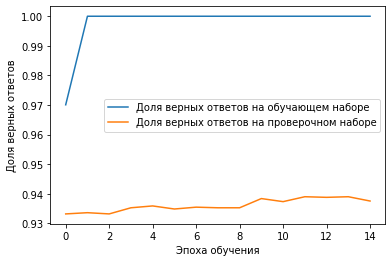

In [ ]:
# Полносвязная модель

model01 = Sequential()
model01.add(Dense(2000, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.2))
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=15,
                      batch_size=32,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/15
423/423 [==============================] - 22s 52ms/step - loss: 0.1982 - accuracy: 0.9239 - val_loss: 1.1000 - val_accuracy: 0.7713
Epoch 2/15
423/423 [==============================] - 21s 51ms/step - loss: 6.5869e-04 - accuracy: 0.9999 - val_loss: 0.8042 - val_accuracy: 0.8211
Epoch 3/15
423/423 [==============================] - 22s 51ms/step - loss: 9.8224e-06 - accuracy: 1.0000 - val_loss: 0.7781 - val_accuracy: 0.8178
Epoch 4/15
423/423 [==============================] - 21s 51ms/step - loss: 5.5587e-06 - accuracy: 1.0000 - val_loss: 0.7691 - val_accuracy: 0.8172
Epoch 5/15
423/423 [==============================] - 22s 51ms/step - loss: 4.0672e-06 - accuracy: 1.0000 - val_loss: 0.7688 - val_accuracy: 0.8159
Epoch 6/15
423/423 [==============================] - 23s 53ms/step - loss: 3.1218e-06 - accuracy: 1.0000 - val_loss: 0.7723 - val_accuracy: 0.8143
Epoch 7/15
423/423 [==============================] - 23s 53ms/step - loss: 2.4602e-06 - accuracy: 1.0000 - val_loss

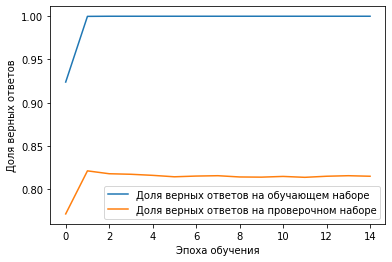

In [ ]:
# Embedding + Conv1D модель

model = Sequential()
model.add(Embedding(maxWordsCount, 200, input_length = xLen))
model.add(Conv1D(256, 5, padding='same', activation="relu"))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain, 
                      yTrain, 
                      epochs=15,
                      batch_size=32,
                      validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Итог xLen = 5000. 98% 

In [ ]:
xLen = 5000 # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы

xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

Epoch 1/15
416/416 [==============================] - 3s 7ms/step - loss: 0.0351 - accuracy: 0.9851 - val_loss: 0.1568 - val_accuracy: 0.9793
Epoch 2/15
416/416 [==============================] - 3s 6ms/step - loss: 4.6885e-05 - accuracy: 1.0000 - val_loss: 0.1354 - val_accuracy: 0.9786
Epoch 3/15
416/416 [==============================] - 3s 6ms/step - loss: 1.8587e-05 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 0.9788
Epoch 4/15
416/416 [==============================] - 3s 6ms/step - loss: 9.7941e-06 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9788
Epoch 5/15
416/416 [==============================] - 3s 6ms/step - loss: 5.8008e-06 - accuracy: 1.0000 - val_loss: 0.1200 - val_accuracy: 0.9793
Epoch 6/15
416/416 [==============================] - 3s 6ms/step - loss: 3.9465e-06 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 0.9790
Epoch 7/15
416/416 [==============================] - 3s 6ms/step - loss: 2.8756e-06 - accuracy: 1.0000 - val_loss: 0.1128 - val

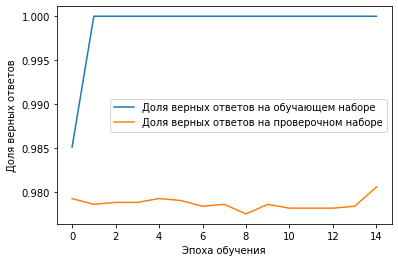

In [ ]:
# Полносвязная модель

model01 = Sequential()
model01.add(Dense(2000, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.2))
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=15,
                      batch_size=32,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

    #Для каждого из 6 классов
    #Создаём тестовую выборку из индексов
    nClasses = len(wordIndexes) #Задаем количество классов
    xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
    xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
    for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
        sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
        xTest6Classes.append(sample)              # Добавляем в список
        xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
    xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
    xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 

    return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, _ = createTestMultiClasses(testWordIndexes, xLen, step) # Преобразование тестовой выборки

In [ ]:
# Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 98% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   96% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     97% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       97% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 98%

